# Import and load dataset

In [10]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
pd.set_option('max_colwidth', 150)

In [7]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 0845281007...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


<AxesSubplot:ylabel='label'>

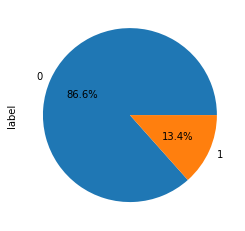

In [31]:
ratio_spam_and_ham = df["label"].value_counts()
ratio_spam_and_ham.plot.pie(autopct = '%1.1f%%')

# Preprocessing

In [11]:
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=44, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


In [12]:
vocab_size = 1500
oov_tok = "<OOV>"
embedding_dim = 16

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences)

max_sequence_len = max([len(x) for x in sequences])

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_sequence_len)

In [13]:
training_padded = np.array(padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

print(training_padded.shape)
print(training_labels.shape)
print(testing_padded.shape)
print(testing_labels.shape)

(3900, 189)
(3900,)
(1672, 189)
(1672,)


# Model Building

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_sequence_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
adam = tf.keras.optimizers.Adam(learning_rate=0.005)

In [16]:
model.compile(loss='binary_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 16)           24000     
_________________________________________________________________
bidirectional (Bidirectional (None, 189, 64)           12544     
_________________________________________________________________
conv1d (Conv1D)              (None, 185, 64)           20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 46, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2944)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2944)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                7

# Training

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [18]:
checkpoint_filepath = '../saved_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
num_epochs = 20
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stopping, model_checkpoint_callback],
                    verbose=1)

Epoch 1/20
122/122 [==============================] - 11s 67ms/step - loss: 0.1983 - accuracy: 0.9226 - val_loss: 0.1216 - val_accuracy: 0.9821
Epoch 2/20
122/122 [==============================] - 8s 62ms/step - loss: 0.1092 - accuracy: 0.9808 - val_loss: 0.1071 - val_accuracy: 0.9886
Epoch 3/20
122/122 [==============================] - 8s 62ms/step - loss: 0.0784 - accuracy: 0.9900 - val_loss: 0.1334 - val_accuracy: 0.9533
Epoch 4/20
122/122 [==============================] - 8s 62ms/step - loss: 0.0710 - accuracy: 0.9872 - val_loss: 0.1024 - val_accuracy: 0.9671
Epoch 5/20
122/122 [==============================] - 8s 62ms/step - loss: 0.0404 - accuracy: 0.9923 - val_loss: 0.0592 - val_accuracy: 0.9862
Epoch 6/20
122/122 [==============================] - 8s 63ms/step - loss: 0.0190 - accuracy: 0.9941 - val_loss: 0.0643 - val_accuracy: 0.9850
Epoch 7/20
122/122 [==============================] - 8s 64ms/step - loss: 0.0094 - accuracy: 0.9982 - val_loss: 0.0941 - val_accuracy: 0.987

# Model Accuracy-Loss Plot

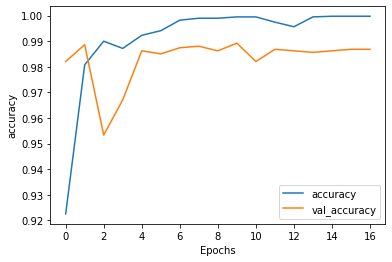

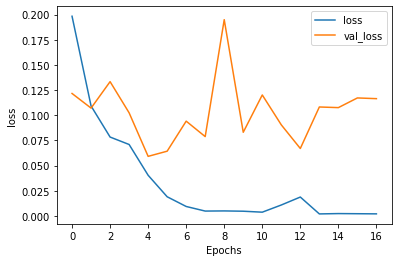

In [20]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### classification_report

In [32]:
threshold = 0.5

result = model.predict(testing_padded, verbose=2)
result = result > threshold
result = result.astype(int)

53/53 - 1s


In [34]:
from sklearn.metrics import classification_report
target_names = ['ham','spam']
print(classification_report(testing_labels, result, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1448
        spam       0.96      0.94      0.95       224

    accuracy                           0.99      1672
   macro avg       0.98      0.97      0.97      1672
weighted avg       0.99      0.99      0.99      1672



### confusion_matrix

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testing_labels, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

,ham,spam
ham,1439,9
spam,13,211


### AUC

AUC: 0.9678744080505128


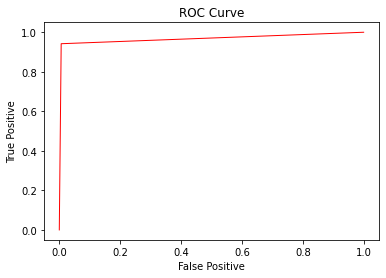

In [36]:
from sklearn import metrics
print("AUC:",metrics.roc_auc_score(testing_labels, result))
cutoff_grid = np.linspace(0.0,1.0,100)
TPR = []
FPR = []
cutoff_grid
FPR, TPR, cutoffs = metrics.roc_curve(testing_labels, result,pos_label=1)
plt.plot(FPR,TPR,c='red',linewidth=1.0)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.show()

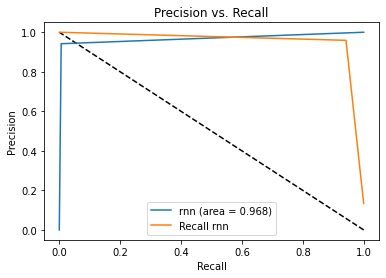

In [37]:
fpr_en, tpr_en, thresholds_en = metrics.roc_curve(testing_labels, result)
roc_auc_en = metrics.auc(fpr_en, tpr_en)
precision_en, recall_en, th_en = metrics.precision_recall_curve(testing_labels, result)
plt.plot([1, 0], [0, 1], 'k--')
plt.plot(fpr_en, tpr_en, label='rnn (area = %0.3f)' % roc_auc_en)
plt.plot(recall_en,precision_en , label='Recall rnn')
plt.title('Precision vs. Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

# Save Model

In [38]:
model.save("./final_model.h5")

## Model Testing

In [39]:
from keras.models import load_model
loadedModel = load_model("./final_model.h5")
testText = str(input("Please , Enter Message\n"))
testText = tokenizer.texts_to_sequences(testText)
testText = pad_sequences(testText, maxlen=max_sequence_len)
threshold = 0.5
result = model.predict(testText, verbose=2)
result = result > threshold
result = result.astype(int)
if result[0] == 1:
    print("Spam")
elif result[0] == 0:
    print("Ham")

2/2 - 0s
Ham


***Russel C.***

In [ ]:
# https://www.kaggle.com/farizhaykal/sms-spam-detection-ann-96-mean-val-accuracy
# Eveluation sample
"""
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print("Accuracy Score:", accuracy_score(y_test,y_pred)*100,"%")

fig, ax = plt.subplots(1,figsize=(6,6))
labels=['No','Yes']
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False,ax=ax)
plt.suptitle('Confusion Matrix', fontsize=30)
ax.set_title('Accurcay Score')
ax.set_yticklabels(labels);
ax.set_xticklabels(labels);
ax.set_ylabel('Test',fontsize=20)
ax.set_xlabel('Predicted',fontsize=20)
    """